## Huggingface VLM fine tune

In [5]:
from huggingface_hub import login
HF_TOKEN = ""
login(HF_TOKEN)

## Import Dependencies

In [2]:
%pip install pillow pypdfium2 num2words addict wandb

In [3]:
%pip install trl

# wandb login

In [4]:
import wandb

wandb.login(key="")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jarviszhang (jarviszhang-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
import transformers
import trl

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


## Load dataset

VLM datasets follow the main structure of "image + text pairs".

For example, you in put an image, what text do you want out?

I created this dataset to be:

* 1000 food images (from Food101)
* 500 not food images (randomly sampled from the internet)

The images were labelled to extract food/drink items with [`Qwen3-VL-8B-Instruct`](https://huggingface.co/Qwen/Qwen3-VL-8B-Instruct) (a larger VLM) and then turned into a [Hugging Face Image Dataset](https://huggingface.co/docs/datasets/en/image_dataset#imagefolder). 

> **Resource:** If you'd like to see how I created this dataset, refer to the [livestream I did on YouTube](https://www.youtube.com/live/X-nYCCviCyI?si=kPKhTxXbc7pUztAC) where I build the dataset and uploaded it to Hugging Face.

In [7]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("mrdbourke/FoodExtract-1k-Vision")
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_name', 'food101_class_name', 'food101_split', 'image_source', 'qwen3_vl_8b_yaml_out', 'qwen3_vl_inference_time', 'output_label_json', 'is_food', 'image'],
        num_rows: 1510
    })
})

In [8]:
example_sample = dataset["train"][0]

example_sample

{'image_id': '3233632',
 'image_name': '3233632.jpg',
 'food101_class_name': 'cheese_plate',
 'food101_split': 'train',
 'image_source': 'food101',
 'qwen3_vl_8b_yaml_out': 'point_of_view: 45-degree\ndishes:\n  - cheese plate\nfood_items:\n  - cheese wedge\n  - toast\n  - herb garnish\n  - dipping sauce\ndrink_items: []\ncontainers_and_utensils:\n  - white plate\n  - small white bowl\nattributes:\n  - sliced\n  - garnished\n  - served with accompaniments',
 'qwen3_vl_inference_time': 1.6110260486602783,
 'output_label_json': {'is_food': 1,
  'image_title': 'cheese plate',
  'food_items': ['toast', 'herb garnish', 'dipping sauce', 'cheese wedge'],
  'drink_items': []},
 'is_food': 1,
 'image': <PIL.Image.Image image mode=RGB size=512x512>}

[INFO] Example desired output:
{'is_food': 1, 'image_title': 'cheese plate', 'food_items': ['toast', 'herb garnish', 'dipping sauce', 'cheese wedge'], 'drink_items': []}
[INFO] Example image input:


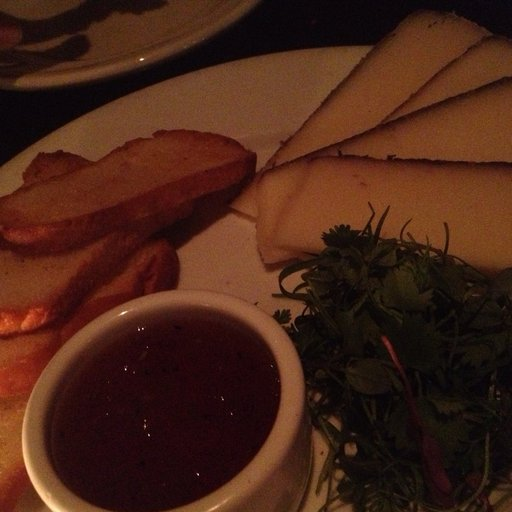

In [9]:
example_input = example_sample["image"]
example_output = example_sample["output_label_json"]

print(f"[INFO] Example desired output:\n{example_output}")

print(f"[INFO] Example image input:")
example_input

## Format data for use with a VLM

Our VLM input requires our data to be formatted in a conversational style.

We'll use two prompts to try and help the model: 

```
SYSYTEM_MESSAGE = """You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
As well as titling the image with a simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""
```

And

````
USER_PROMPT = """Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.

Only return valid JSON in the following form:

```json
{
  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
  'food_items': [], # list[str] - list of visible edible food item nouns
  'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""
````

To begin, we'll see how the base model performs using just these prompts.

In [10]:
# System message
SYSYTEM_MESSAGE = """You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
As well as titling the image with a simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""

# User prompt with image input as well as desired output
USER_PROMPT = """Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.

Only return valid JSON in the following form:

```json
{
  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
  'food_items': [], # list[str] - list of visible edible food item nouns
  'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""

# Create helper function to map our input/output samples to conversational format
def format_data(sample):
    return {
        "messages": [

            # Message 0 - [SYSTEM] System Prompt (setting the scene)
            {
                "role": "system",
                "content": [{"type": "text", "text": SYSYTEM_MESSAGE}]
            },

            # Message 1 - [USER] User input (image + prompt pair)
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": sample["image"],
                    },
                    {
                        "type": "text",
                        "text": USER_PROMPT # Note: In a future extension, you might train the model to not require any text input and just go straight from image -> text output
                    }
                ],
            },

            # Message 2 - [MODEL] Ideal model output (e.g. our structured data format)
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["output_label_json"]}] #SFT
            }
        ]
    }

formatted_sample = format_data(sample=example_sample)
formatted_sample

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x512>},
    {'type': 'text',
     'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods pr

In [11]:
# Format each item in the original dataset keeping the PIL image type
dataset_processed = [format_data(sample) for sample in dataset["train"]]
dataset_processed[1]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x384>},
    {'type': 'text',
     'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods pr

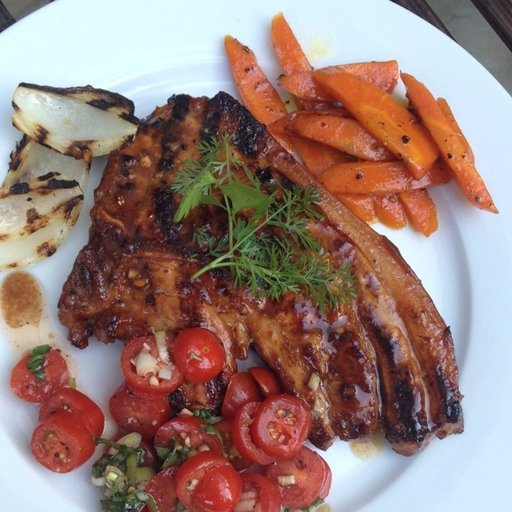

In [12]:
dataset_processed[2]['messages'][1]['content'][0]['image']


### Create a training and validation split

We will fine-tune on the training data and then evaluate our model on the validation data.

In [13]:
import random
from pprint import pprint

random.seed(42)
dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

# Use 80% split for training, 20% for validation
train_split = round(0.8 * len(dataset_shuffled))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]
print(f"[INFO] Number of total samples: {len(dataset_processed)}")
print(f"[INFO] Number of train samples: {len(train_dataset)}")
print(f"[INFO] Number of eval samples: {len(val_dataset)}")

print(f"\n[INFO] Example training sample:\n")
pprint(train_dataset[0])
print(f"\n[INFO] Example validation sample:\n")
pprint(val_dataset[0])

[INFO] Number of total samples: 1510
[INFO] Number of train samples: 1208
[INFO] Number of eval samples: 302

[INFO] Example training sample:

{'messages': [{'content': [{'text': 'You are an expert food and drink image '
                                    'extractor.\n'
                                    'You provide structured data to visual '
                                    'inputs classifying them as edible '
                                    'food/drink or not.\n'
                                    'As well as titling the image with a '
                                    'simple food/drink related caption.\n'
                                    'Finally you extract any and all visible '
                                    'food/drink items to lists.\n',
                            'type': 'text'}],
               'role': 'system'},
              {'content': [{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x678 at 0x7CECA173EF90>,
                     

## Running a sample through a base model

Let's see how a non-fine-tuned model performs on our task.

* Let's fine-tune SmolVLM2-256M or SmolVLM2-500M
    * See collection: https://huggingface.co/collections/HuggingFaceTB/smolvlm2-smallest-video-lm-ever 
* Previous efforts we tried gemma-3n-E3B-it but it was already too good:
    * ~To begin with we'll try out Gemma-3n-E2B-it - https://huggingface.co/google/gemma-3n-E2B-it~

In [14]:
# Get a base model input example
# We only want our model to see the user system/user inputs (not the desired response) so we index on the correct amount of messages
example_base_model_input = dataset_processed[0]["messages"][:2] # the "assistant" text output is what we want our model to predict
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items

### Loading a base model

There are many different VLMs we could try.

But for this project, we're going to focus on small (under 1B parameters).

In previous experiments I tried `google/gemma-3n-e2b-it` (5B parameters) and it performed quite well on our task.

For now we'll stick with [`HuggingFaceTB/SmolVLM2-500M-Video-Instruct`](https://huggingface.co/HuggingFaceTB/SmolVLM2-500M-Video-Instruct), a model 10x smaller than `google/gemma-3n-e2b-it`.

So it's a good place to start to try and make it perform on par with a larger model.

> **Resource:** You can find many base models the Hugging Face Models page under the `Image-Text-to-Text` filter: https://huggingface.co/models?pipeline_tag=image-text-to-text

We can load a model and perform inference quite quickly using the `transformers.pipeline` class.

> **Note:** `transformers.pipeline` is mainly for getting quick inference from a model. For fine-tuning, we'll be using the `transformers.AutoModelForImageTextToText` class.

In [15]:
import torch
# Other models to try
# MODEL_ID = "google/gemma-3n-e2b-it" # note: this model is 5B parameters and performs quite well, however, it's not quite as "small" as we'd like

MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"

MODEL_ID_PHI = 'microsoft/Phi-3.5-vision-instruct'




In [16]:
from transformers import pipeline
pipe = pipeline(
    "image-text-to-text",
    model=MODEL_ID,
    device="cuda",
    dtype=torch.bfloat16
)

Device set to use cuda


In [17]:
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items

## Run model

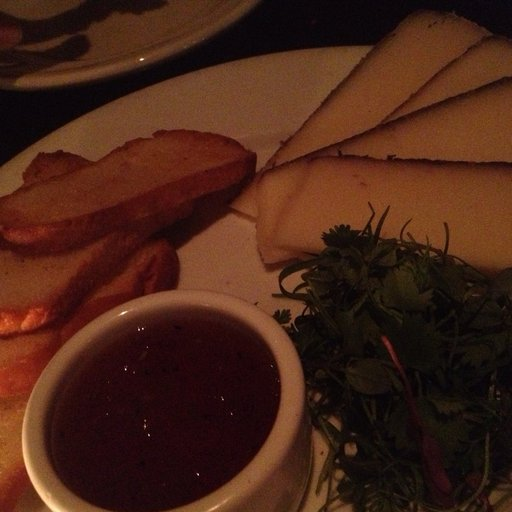

In [18]:
# Check example input image
example_base_model_input[1]["content"][0]["image"]

In [19]:
# Test the base model on an example input image
base_model_output = pipe(text=example_base_model_input,
                         max_new_tokens=256)

print(f'[INFO] Base model input (text only):\n{example_base_model_input}\n')
print(f'[INFO] Base model output:\n{base_model_output[0]["generated_text"][-1]["content"]}\n')
print(f'[INFO] Desired output:\n{dataset_processed[0]["messages"][-1]["content"][0]["text"]}')

[INFO] Base model input (text only):
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7CECA3F5ECC0>}, {'type': 'text', 'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank

In [20]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

print(f"[INFO] Using model: {MODEL_ID}")

# Define model init args 
model_kwargs = dict(
    attn_implementation="eager", # Note: could also use flash_attention_2 here for faster models, requires `pip install flash-attn` (see: https://github.com/Dao-AILab/flash-attention)
    dtype=torch.bfloat16,
    device_map="auto"
)

# Load the model and tokenizer/processor
model_SmolVLM2 = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
                                                    **model_kwargs)
processor_SmolVLM2 = AutoProcessor.from_pretrained(MODEL_ID)

[INFO] Using model: HuggingFaceTB/SmolVLM2-500M-Video-Instruct


In [21]:
model_SmolVLM2

SmolVLMForConditionalGeneration(
  (model): SmolVLMModel(
    (vision_model): SmolVLMVisionTransformer(
      (embeddings): SmolVLMVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): SmolVLMEncoder(
        (layers): ModuleList(
          (0-11): 12 x SmolVLMEncoderLayer(
            (self_attn): SmolVLMVisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): SmolVLMVisionMLP(
              (activation_fn): GELUTanh()
              (fc1): Linear(in_features=768, out_feature

## Apply the chat template 

In [22]:
# Apply the chat template 

dtype = torch.float32 if device == "mps" else torch.bfloat16

example_chat_template_input = processor_SmolVLM2.apply_chat_template(
    [example_base_model_input[1]], # Note: if we are running this way, format the system_prompt to either be removed or folded into the user_prompt
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(device)
print(f"[INFO] Chat template:\n{example_chat_template_input}\n")


# Measure how long our input prompt is (our model will generate tokens *after* the input prompt)
input_len = example_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

# Perform inference with the base model
with torch.no_grad():
    generation_output_full = model_SmolVLM2.generate(**example_chat_template_input,
                                            max_new_tokens=256,
                                            do_sample=False)
    generation_output_short = generation_output_full[0][input_len:]

# Decode the outputs from tokens -> readable text
decoded_outputs = processor_SmolVLM2.decode(generation_output_short,
                                   skip_special_tokens=True)

# Print inputs and outputs
print("Model: SmolVLM2")
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the raw token (numerical) intput to our model:\n")
print(example_chat_template_input["input_ids"][0])
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the raw pixel values (numerical) intput to our model:\n")
print(example_chat_template_input["pixel_values"][0])
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the input to our model in human-readable form (note: our model will not see in the input like this):\n")
print(processor_SmolVLM2.decode(example_chat_template_input["input_ids"][0]))
print("\n"+"-"*50+"\n")
print(f"[INFO] Outputs from the base model:\n")
print(decoded_outputs)

[INFO] Chat template:
{'pixel_values': tensor([[[[[-0.3804, -0.3804, -0.3804,  ..., -0.8431, -0.8431, -0.8353],
           [-0.3804, -0.3804, -0.3804,  ..., -0.8353, -0.8353, -0.8275],
           [-0.3804, -0.3804, -0.3804,  ..., -0.8353, -0.8353, -0.8275],
           ...,
           [-0.9216, -0.9216, -0.9216,  ..., -0.0667, -0.0667, -0.0745],
           [-0.9216, -0.9216, -0.9216,  ..., -0.0667, -0.0667, -0.0745],
           [-0.9137, -0.9137, -0.9137,  ..., -0.0745, -0.0745, -0.0745]],

          [[-0.6549, -0.6549, -0.6549,  ..., -0.9216, -0.9216, -0.9059],
           [-0.6549, -0.6549, -0.6549,  ..., -0.9137, -0.9137, -0.8980],
           [-0.6549, -0.6549, -0.6549,  ..., -0.9137, -0.9137, -0.8980],
           ...,
           [-0.9608, -0.9608, -0.9608,  ..., -0.4275, -0.4275, -0.4353],
           [-0.9608, -0.9608, -0.9608,  ..., -0.4275, -0.4275, -0.4353],
           [-0.9608, -0.9608, -0.9608,  ..., -0.4353, -0.4353, -0.4353]],

          [[-0.8039, -0.8039, -0.8039,  ..., -0.9

## Prepare model for training

As per the [SmolDocling paper (section 5.1)](https://arxiv.org/pdf/2503.11576), we're going to freeze the `vision_model` and train the rest of the model (the LLM parts).

If we had a larger dataset (our dataset is quite small at ~1000 training samples), we could potentially perform two stage training by:

1. Training with a frozen vision encoder to align the LLM portions of the model to the output (our desired format).
2. Training the whole model to align all features to our target dataset.

For now, we are going to focus on stage one.

Let's count the overall parameters and trainable parameters in our model before and after freezing the vision encoder.

In [23]:
model_SmolVLM2.model.vision_model

SmolVLMVisionTransformer(
  (embeddings): SmolVLMVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    (position_embedding): Embedding(1024, 768)
  )
  (encoder): SmolVLMEncoder(
    (layers): ModuleList(
      (0-11): 12 x SmolVLMEncoderLayer(
        (self_attn): SmolVLMVisionAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SmolVLMVisionMLP(
          (activation_fn): GELUTanh()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1

## Freeze the vision backbone and only train the LLM parts

In [24]:
# Freeze the vision backbone and only train the LLM parts
def count_parameters(model):
    total = sum(p.numel() for p in model_SmolVLM2.parameters())
    trainable = sum(p.numel() for p in model_SmolVLM2.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen 

# Before freezing parameters
total_params, trainable_params, frozen_params = count_parameters(model_SmolVLM2)
print(f"[INFO] Params Total (before freezing the vision model): {total_params:,} | Params Trainable: {trainable_params:,} | Params Frozen: {frozen_params:,}")

# Freeze the vision encoder
for param in model_SmolVLM2.model.vision_model.parameters():
    # Turn off graidents in the vision model
    param.requires_grad = False

# After freezing parameters
total_params, trainable_params, frozen_params = count_parameters(model_SmolVLM2)
print(f"[INFO] Params Total (after freezing the vision model): {total_params:,} | Params Trainable: {trainable_params:,} | Params Frozen: {frozen_params:,}")

[INFO] Params Total (before freezing the vision model): 507,482,304 | Params Trainable: 507,482,304 | Params Frozen: 0
[INFO] Params Total (after freezing the vision model): 507,482,304 | Params Trainable: 421,049,280 | Params Frozen: 86,433,024


## Creating a data collator

A data collator helps stack our image + text samples into batches. 

This tells the `transformer.Trainer` how to put multiple samples into a batch for more efficient training.

To do this we'll create two functions:

1. `convert_message_to_list_of_images` - Extracts the images from an input list of messages (our image + text pairs) to a list.
2. `collate_fn` - Preprocesses groups of image and text pairs into batches for our model to train on.

In [24]:
def convert_message_to_list_of_images(messages: list[dict]) -> list[Image.Image]:
    """Helper function to turn our message samples into lists of images.
    
    Note: this comes from here: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora"""
    image_inputs = []
    
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
                
    return image_inputs

def collate_fn(examples):
    """Helper function to stack together image + text pairs into batches."""
    
    # Create empty lists for batches of text and images
    texts = []
    images = []

    # Loop through examples and preprocess them
    for example in examples:
        image_inputs = convert_message_to_list_of_images(example["messages"])
        text = processor_SmolVLM2.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)
    
    # Tokenize the texts and process the images
    batch_input = processor_SmolVLM2(text=texts, 
                            images=images, 
                            return_tensors="pt",
                            padding=True) 
    
    # The labels are the input_ids and we mask the padding tokens and image tokens in the loss computation
    labels = batch_input["input_ids"].clone()

    # Get the image token
    image_token_id = processor_SmolVLM2.tokenizer.additional_special_tokens_ids[
            processor_SmolVLM2.tokenizer.additional_special_tokens.index("<image>")]

    # Mask tokens for not being used in the loss computation
    labels[labels == processor_SmolVLM2.tokenizer.pad_token_id] = -100 # pad_token_id = 2
    labels[labels == image_token_id] = -100 # image_token_id = 49190, this is the `<image>` token which is a placeholder, we don't need our model to learn to predict those

    batch_input["labels"] = labels
    
    return batch_input

# For SmolVLM2, check the image token
image_token_id = processor_SmolVLM2.tokenizer.additional_special_tokens_ids[
            processor_SmolVLM2.tokenizer.additional_special_tokens.index("<image>")]
print(f"[INFO] SmolVLM2 uses the following for the image_token_id: {image_token_id}, we mask this token as it is only a placeholder in our sequence of tokens (we don't need the model to learn to predict it).")

[INFO] SmolVLM2 uses the following for the image_token_id: 49190, we mask this token as it is only a placeholder in our sequence of tokens (we don't need the model to learn to predict it).


## Setup SFTConfig

We're going to use SFT (Supervised Fine-Tuning) which is a method of training where we provide input + output pairs for our model. 

Given an input and output pair, our model will be directly trained to predict the output based on the input.

To enable SFT training, we're going to use the following two classes:

1. Setup `SFTConfig` (Supervised Fine-Tuning Config) - these are hyperparameter settings which tell our model *how* to train, see docs:  https://huggingface.co/docs/trl/en/sft_trainer#trl.SFTConfig
2. Setup `SFTTrainer` (Supervised Fine-Tuning Trainer) - this will tell our model *what* to train on, see docs:  https://huggingface.co/docs/trl/en/sft_trainer#trl.SFTTrainer


In [32]:
from trl import SFTConfig

# Note: Many of these hyperparameters have been taken from the SmolDocling paper: https://arxiv.org/abs/2503.11576
training_args = SFTConfig(
    output_dir="smolvlm2-500m-FoodExtract-Vision",

    # Wandb 
    run_name="smolvlm2-food-extract-v1",  
    report_to="wandb",  
    
    dataloader_num_workers=4,        # 添加：多线程加载数据
    dataloader_pin_memory=True,      # 添加：加速数据传输
    
    num_train_epochs=4, # depending on how much data you have you may want to train for shorter/longer
    per_device_train_batch_size=4, # adjust based on the size of your GPU
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=1,
    max_grad_norm=1.0, 
    warmup_ratio=0.03, 
    lr_scheduler_type="constant",
    push_to_hub=False,
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    load_best_model_at_end=True,
    remove_unused_columns = False 
)

## Train the model with SFTTrainer

In [33]:
len(train_dataset), len(val_dataset)

(1208, 302)

In [34]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model_SmolVLM2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, 
    # train_dataset=train_dataset[:50], # Lowered for the video (faster)
    # eval_dataset=val_dataset[:10], # Lowered for the video (faster)
    # peft_config=peft_config, # Note: We are not using PEFT but if we did, we could pass it in here
    processing_class=processor_SmolVLM2,
    data_collator=collate_fn
)


The model is already on multiple devices. Skipping the move to device specified in `args`.


### initialize wandb project

## Train VLM model

In [ ]:
# # 初始化 wandb 项目
# wandb.init(
#     project="vlm-food-extraction",  # 项目名称，可以自定义
#     name="smolvlm2-500m-finetune",  # 这次运行的名称
#     config={
#         "model": MODEL_ID,
#         "train_samples": len(train_dataset),
#         "val_samples": len(val_dataset),
#         "architecture": "SmolVLM2-500M",
#         "task": "food-extraction"
#     }
# )
# trainer.train()

Epoch,Training Loss,Validation Loss
1,0.084200,0.075854
2,0.081600,0.075661
3,0.023700,0.075108
4,0.017200,0.080667


TrainOutput(global_step=304, training_loss=0.05179583847731058, metrics={'train_runtime': 1510.0433, 'train_samples_per_second': 3.2, 'train_steps_per_second': 0.201, 'total_flos': 1.890218669598259e+16, 'train_loss': 0.05179583847731058})

# Save the model to file 

In [37]:
# Save the model to file 
trainer.save_model()

In [38]:
! cd smolvlm2-500m-FoodExtract-Vision && ls

added_tokens.json	  processor_config.json
chat_template.jinja	  README.md
checkpoint-228		  special_tokens_map.json
config.json		  tokenizer_config.json
generation_config.json	  tokenizer.json
merges.txt		  training_args.bin
model.safetensors	  video_preprocessor_config.json
preprocessor_config.json  vocab.json


## Plot the training/validation loss curves

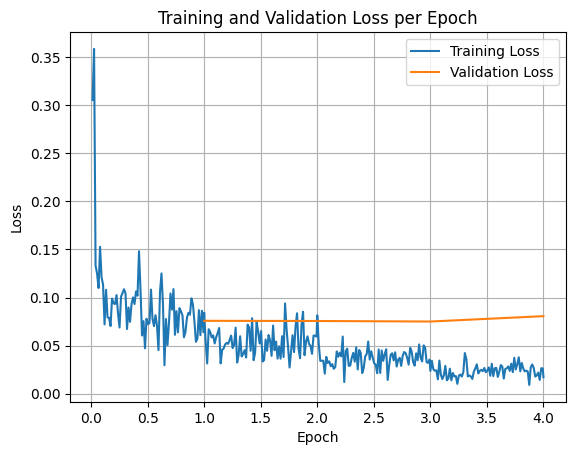

In [39]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Upload the fine-tuned model to the Hugging Face Hub

> **Note:** Make sure you are authenticated to the Hugging Face Hub via the [`huggingface_hub` package](https://huggingface.co/docs/huggingface_hub/en/guides/cli) to enable smooth uploads.
>
> See the [`hf auth login` command](https://huggingface.co/docs/huggingface_hub/en/guides/cli#hf-auth-login) for details on how to obtain an authorization token to link your computer to your Hugging Face profile via a [User Access Token](https://huggingface.co/docs/hub/security-tokens).

In [40]:
# Optional: Remove the checkpoints from the saved directory (after the model is saved)
!rm -rf smolvlm2-500m-FoodExtract-Vision/checkpoint-*

In [41]:
# Upload to Hugging Face
from huggingface_hub import HfApi, create_repo


api = HfApi()

# Give our model a name (this is in the format [Hugging Face Username]/[Target Model Name]
repo_id = "CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune"

# Create the repo
create_repo(repo_id, 
            repo_type="model", 
            exist_ok=True)

# Upload the entire model folder containing our model files
api.upload_folder(
    folder_path="./smolvlm2-500m-FoodExtract-Vision/",
    repo_id=repo_id,
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-Vision/model.safetensors:   0%|          | 51.3kB / 1.02GB            

  ...-Vision/training_args.bin:  16%|#6        | 1.05kB / 6.35kB            

CommitInfo(commit_url='https://huggingface.co/CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune/commit/baf2d35e0419e799cdb907fb3264e17e56f73735', commit_message='Upload folder using huggingface_hub', commit_description='', oid='baf2d35e0419e799cdb907fb3264e17e56f73735', pr_url=None, repo_url=RepoUrl('https://huggingface.co/CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune', endpoint='https://huggingface.co', repo_type='model', repo_id='CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune'), pr_revision=None, pr_num=None)

## Test the fine-tuned model against the base model

### Delete the existing model

In [42]:
# Delete the existing model and trainer and clear the cache for fresh inference
del model_SmolVLM2
del trainer
torch.cuda.empty_cache()

### Use this for the model that was just trained from Huggingface

In [28]:

#Load fine-tuned model from the Hugging Face Hub
MODEL_ID_Jarvis = "CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune"
MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"

print(f"[INFO] Using fine-tuned checkpoint: {MODEL_ID_Jarvis}")
print(f"[INFO] Using base model checkpoint: {MODEL_ID}")

[INFO] Using fine-tuned checkpoint: CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune
[INFO] Using base model checkpoint: HuggingFaceTB/SmolVLM2-500M-Video-Instruct


In [29]:
from transformers import pipeline
import torch

# Load the base model (pt_pipe stands for "pretrained pipeline", 'pretrained model' is another word for 'base model'
pt_pipe = pipeline(
    "image-text-to-text",
    model=MODEL_ID,
    dtype=torch.bfloat16
)

# `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor_SmolVLM2.tokenizer.eos_token_id

# Load the fine-tuned model
ft_pipe = pipeline(
    "image-text-to-text",
    model=MODEL_ID_Jarvis,
    dtype=torch.bfloat16
)

# `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = True
ft_pipe.model.generation_config.pad_token_id = processor_SmolVLM2.tokenizer.eos_token_id

Device set to use cuda:0


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/403 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/944 [00:00<?, ?B/s]

Device set to use cuda:0


##

[INFO] Example model input:
{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=512x384 at 0x7CECA1AF0830>}, {'type': 'text', 'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items': [], # list[str] - list of visible edible food item nouns\n  'drink_items': [] # list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

[INFO] Example model ideal output:
{'is_food': 1, 'image_title': 'macaron assortment', 'food_items': ['yellow macaron', 'white macaron', 'green macaron', 'brown macaron (p

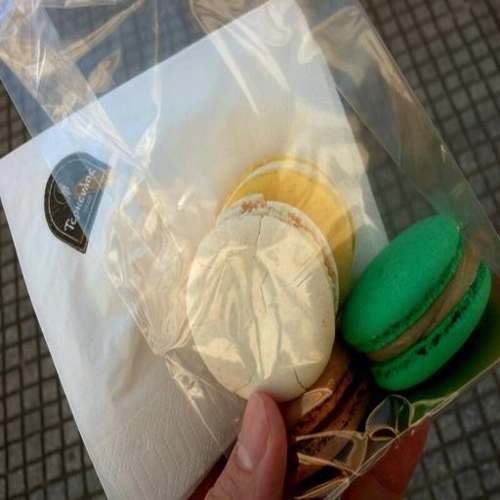

In [31]:
import random

# Pick a random sample from the validation dataset
random_val_sample = random.choice(val_dataset)
random_val_sample_model_input = random_val_sample["messages"][1]
random_val_sample_image = random_val_sample_model_input["content"][0]["image"]
random_val_sample_model_output = random_val_sample["messages"][-1]

# Print out the ideal input and outputs
print(f"[INFO] Example model input:\n{random_val_sample_model_input}")
print()
print(f"[INFO] Example model ideal output:\n{random_val_sample_model_output["content"][0]["text"]}")

# Perform a forward pass with the base model
pt_pipe_output = pt_pipe(text=[random_val_sample_model_input],
                         max_new_tokens=256)
pt_pipe_output_text = pt_pipe_output[0]["generated_text"][-1]["content"]
print(f"\n[INFO] Generated output text from pre-trained model:\n{pt_pipe_output_text}\n")

# Perform a forward pass with the fine-tuned model
ft_pipe_output = ft_pipe(text=[random_val_sample_model_input],
                         max_new_tokens=256)
ft_pipe_output_text = ft_pipe_output[0]["generated_text"][-1]["content"]
print(f"\n[INFO] Generated output text from fine-tuned model:\n{ft_pipe_output_text}\n")

print(f"[INFO] Intput image:")
random_val_sample_image.resize(size=(500, 500))

## Create a demo with Gradio

We need 3 files:

* `app.py` - Entry point for our app to load on Hugging Face Spaces.
* `requirements.txt` - The requirements we'd like Hugging Face Spaces to install upon loading.
* `README.md` - Some details about our demo.

In [ ]:
# Make a directory to store our demos
!mkdir demos
!mkdir demos/FoodExtract-Vision-v1


### app.py

In [ ]:
%%writefile demos/FoodExtract-Vision-v1/app.py

import os
import torch
import gradio as gr
import spaces
from transformers import pipeline

BASE_MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"
FINE_TUNED_MODEL_ID = "CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune"
OUTPUT_TOKENS = 256
original_pipeline = None
ft_pipe = None

FORCE_CPU = os.getenv("FORCE_CPU", "0") == "1"
DEVICE_TYPE = "cuda" if (torch.cuda.is_available() and not FORCE_CPU) else "cpu"
if DEVICE_TYPE == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

def _get_dtype(device: str):
    if device == "cuda":
        if os.getenv("USE_FP16", "0") == "1":
            return torch.float16
        if os.getenv("USE_BF16", "0") == "1":
            is_bf16_supported = getattr(torch.cuda, "is_bf16_supported", None)
            if callable(is_bf16_supported) and is_bf16_supported():
                return torch.bfloat16
        return torch.float32
    return torch.float32

def _make_pipe(model_id: str, device_type: str):
    dtype = _get_dtype(device_type)
    device_arg = 0 if device_type == "cuda" else -1
    pipe = pipeline(
        "image-text-to-text",
        model=model_id,
        device=device_arg,
        torch_dtype=dtype,
    )
    model = getattr(pipe, "model", None)
    generation_config = getattr(model, "generation_config", None)
    if generation_config is not None:
        generation_config.do_sample = False
        generation_config.max_new_tokens = OUTPUT_TOKENS
        try:
            generation_config.max_length = None
        except Exception:
            pass
    return pipe

ACTIVE_DEVICE_TYPE = DEVICE_TYPE

def _load_pipes(device_type: str):
    global original_pipeline, ft_pipe, ACTIVE_DEVICE_TYPE
    ACTIVE_DEVICE_TYPE = device_type
    print(f"[INFO] Using device_type={ACTIVE_DEVICE_TYPE}")
    original_pipeline = _make_pipe(BASE_MODEL_ID, ACTIVE_DEVICE_TYPE)
    ft_pipe = _make_pipe(FINE_TUNED_MODEL_ID, ACTIVE_DEVICE_TYPE)

_load_pipes(DEVICE_TYPE)

def _extract_generated_text(pipe_output) -> str:
    try:
        item0 = pipe_output[0]
        if isinstance(item0, dict) and "generated_text" in item0:
            gt = item0["generated_text"]
        else:
            gt = pipe_output[0][0]["generated_text"]

        if isinstance(gt, str):
            return gt
        if isinstance(gt, list) and gt:
            last = gt[-1]
            if isinstance(last, dict) and "content" in last:
                return last["content"]
        return str(gt)
    except Exception:
        return str(pipe_output)

def create_message(input_image):
    return [{'role': 'user',
 'content': [{'type': 'image',
   'image': input_image},
  {'type': 'text',
   'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items': [], # list[str] - list of visible edible food item nouns\n  'drink_items': [] # list[str] - list of visible edible drink item nouns\n}\n```\n"}]}]

@spaces.GPU
def extract_foods_from_image(input_image):
    if input_image is None:
        return "Please upload an image", "Please upload an image"

    input_image = input_image.convert("RGB")
    input_image = input_image.resize(size=(512, 512))
    input_message = create_message(input_image=input_image)

    try:
        original_pipeline_output = original_pipeline(text=[input_message])
        outputs_pretrained = _extract_generated_text(original_pipeline_output)

        ft_pipe_output = ft_pipe(text=[input_message])
        outputs_fine_tuned = _extract_generated_text(ft_pipe_output)
    except RuntimeError as e:
        msg = str(e)
        is_cuda_linear_failure = (
            "CUBLAS_STATUS_INVALID_VALUE" in msg
            or "cublasGemmEx" in msg
            or ("CUDA error" in msg and "CUBLAS" in msg)
        )
        if ACTIVE_DEVICE_TYPE == "cuda" and is_cuda_linear_failure:
            try:
                print("[WARN] CUDA GEMM failed, falling back to CPU.")
                _load_pipes("cpu")
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                original_pipeline_output = original_pipeline(text=[input_message])
                outputs_pretrained = _extract_generated_text(original_pipeline_output)
                ft_pipe_output = ft_pipe(text=[input_message])
                outputs_fine_tuned = _extract_generated_text(ft_pipe_output)
            except Exception:
                raise e
        else:
            raise

    return outputs_pretrained, outputs_fine_tuned

CUSTOM_CSS = """
/* Global Theme */
.gradio-container {
    max-width: 1200px !important;
    margin: auto !important;
    font-family: 'Inter', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif !important;
}

/* Header Styling */
.header-container {
    text-align: center;
    padding: 2rem 1rem;
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    border-radius: 16px;
    margin-bottom: 1.5rem;
    box-shadow: 0 4px 20px rgba(102, 126, 234, 0.3);
}

.header-title {
    font-size: 2.2rem !important;
    font-weight: 700 !important;
    color: white !important;
    margin-bottom: 0.5rem !important;
    text-shadow: 0 2px 4px rgba(0,0,0,0.1);
}

.header-subtitle {
    font-size: 1.1rem !important;
    color: rgba(255,255,255,0.9) !important;
    font-weight: 400 !important;
}

/* Card Styling */
.info-card {
    background: linear-gradient(145deg, #f8fafc 0%, #f1f5f9 100%);
    border: 1px solid #e2e8f0;
    border-radius: 12px;
    padding: 1.25rem;
    margin-bottom: 1rem;
    transition: all 0.3s ease;
}

.info-card:hover {
    box-shadow: 0 4px 12px rgba(0,0,0,0.08);
    transform: translateY(-2px);
}

.tech-badge {
    display: inline-block;
    background: linear-gradient(135deg, #3b82f6 0%, #1d4ed8 100%);
    color: white;
    padding: 0.35rem 0.75rem;
    border-radius: 20px;
    font-size: 0.8rem;
    font-weight: 500;
    margin: 0.2rem;
    box-shadow: 0 2px 4px rgba(59, 130, 246, 0.3);
}

/* Output Section */
.output-section {
    background: #fafbfc;
    border-radius: 12px;
    padding: 1rem;
    border: 1px solid #e5e7eb;
}

.comparison-header {
    font-size: 0.9rem;
    font-weight: 600;
    color: #374151;
    margin-bottom: 0.5rem;
    display: flex;
    align-items: center;
    gap: 0.5rem;
}

/* Button Styling */
.primary-btn {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%) !important;
    border: none !important;
    color: white !important;
    font-weight: 600 !important;
    padding: 0.75rem 2rem !important;
    border-radius: 8px !important;
    transition: all 0.3s ease !important;
    box-shadow: 0 4px 12px rgba(102, 126, 234, 0.4) !important;
}

.primary-btn:hover {
    transform: translateY(-2px) !important;
    box-shadow: 0 6px 20px rgba(102, 126, 234, 0.5) !important;
}

/* Links */
.resource-link {
    color: #4f46e5;
    text-decoration: none;
    font-weight: 500;
    transition: color 0.2s;
}

.resource-link:hover {
    color: #7c3aed;
    text-decoration: underline;
}

/* Footer */
.footer-section {
    text-align: center;
    padding: 1.5rem;
    margin-top: 1.5rem;
    border-top: 1px solid #e5e7eb;
    color: #6b7280;
    font-size: 0.9rem;
}

/* Accordion */
.accordion-header {
    font-weight: 600 !important;
    color: #1f2937 !important;
}
"""

with gr.Blocks(css=CUSTOM_CSS, theme=gr.themes.Soft(), title="FoodExtract Vision | Fine-tuned VLM Demo") as demo:
    
    # Header Section
    gr.HTML("""
    <div class="header-container">
        <h1 class="header-title">🍽️ FoodExtract Vision</h1>
        <p class="header-subtitle">Fine-tuned SmolVLM2-500M for Structured Food & Drink Extraction</p>
    </div>
    """)
    
    # Project Overview Cards
    with gr.Row():
        with gr.Column(scale=1):
            gr.HTML("""
            <div class="info-card">
                <h3 style="margin: 0 0 0.75rem 0; color: #1f2937; font-size: 1rem;">🎯 Project Objective</h3>
                <p style="margin: 0; color: #4b5563; font-size: 0.9rem; line-height: 1.6;">
                    Extract food and drink items from images in a <strong>structured JSON format</strong>. 
                    This demo compares the base model vs. fine-tuned model to showcase the improvement in output consistency.
                </p>
            </div>
            """)
        with gr.Column(scale=1):
            gr.HTML("""
            <div class="info-card">
                <h3 style="margin: 0 0 0.75rem 0; color: #1f2937; font-size: 1rem;">🛠️ Tech Stack</h3>
                <div>
                    <span class="tech-badge">SmolVLM2-500M</span>
                    <span class="tech-badge">Transformers</span>
                    <span class="tech-badge">LoRA Fine-tuning</span>
                    <span class="tech-badge">PyTorch</span>
                    <span class="tech-badge">Gradio</span>
                    <span class="tech-badge">HF Spaces</span>
                </div>
            </div>
            """)
    
    # Resources Section
    with gr.Accordion("📚 Model & Dataset Resources", open=False):
        gr.Markdown("""
        | Resource | Link |
        |----------|------|
        | **Base Model** | [HuggingFaceTB/SmolVLM2-500M-Video-Instruct](https://huggingface.co/HuggingFaceTB/SmolVLM2-500M-Video-Instruct) |
        | **Fine-tuned Model** | [CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune](https://huggingface.co/CreatorJarvis/FoodExtract-Vision-SmolVLM2-500M-fine-tune) |
        | **Training Dataset** | [mrdbourke/FoodExtract-1k-Vision](https://huggingface.co/datasets/mrdbourke/FoodExtract-1k-Vision) (1k food + 500 non-food images) |
        """)
    
    gr.Markdown("---")
    
    # Main Demo Section
    gr.HTML('<h2 style="text-align: center; color: #1f2937; margin-bottom: 1rem;">🔬 Live Demo: Model Comparison</h2>')
    
    with gr.Row():
        with gr.Column(scale=1):
            input_image = gr.Image(type="pil", label="📷 Upload Food Image", height=350)
            submit_btn = gr.Button("🚀 Extract Food Items", variant="primary", elem_classes=["primary-btn"])
        
        with gr.Column(scale=1):
            with gr.Group():
                gr.HTML('<div class="comparison-header">❌ Base Model (No Fine-tuning)</div>')
                output_original = gr.Textbox(
                    lines=6, 
                    label="",
                    placeholder="Base model output will appear here...",
                    show_label=False
                )
            with gr.Group():
                gr.HTML('<div class="comparison-header">✅ Fine-tuned Model</div>')
                output_finetuned = gr.Textbox(
                    lines=6, 
                    label="",
                    placeholder="Fine-tuned model output will appear here...",
                    show_label=False
                )
    
    submit_btn.click(
        fn=extract_foods_from_image,
        inputs=[input_image],
        outputs=[output_original, output_finetuned]
    )
    
    # Examples Section
    gr.Markdown("### 📸 Example Images")
    gr.Examples(
        examples=[
            ["examples/food1.jpeg"],
            ["examples/food2.jpg"],
            ["examples/food4.jpeg"]
        ],
        inputs=[input_image],
        outputs=[output_original, output_finetuned],
        fn=extract_foods_from_image,
        cache_examples=False
    )
    
    gr.Markdown("---")
    
    # Technical Details Accordion
    with gr.Accordion("📋 Input Prompt & Expected Output Format", open=False):
        gr.Markdown("""
        **Both models receive the same input prompt:**
        
        ```text
        Classify the given input image into food or not and if edible food or drink items 
        are present, extract those to a list. If no food/drink items are visible, return empty lists.

        Only return valid JSON in the following form:
        ```
        
        **Expected JSON Output Structure:**
        ```json
        {
          "is_food": 1,
          "image_title": "Fresh Garden Salad",
          "food_items": ["lettuce", "tomatoes", "cucumber"],
          "drink_items": []
        }
        ```
        """)
    
    with gr.Accordion("🔮 Future Improvements", open=False):
        gr.Markdown("""
        - **Remove Input Prompt**: Train the model for direct image → JSON conversion to reduce inference tokens
        - **Expand Training Data**: Current dataset is limited to 1.5k images; real-world data would improve generalization
        - **Fix Repetitive Generation**: Address occasional repetitive outputs (e.g., "onions", "onions", "onions")
        - **Multi-language Support**: Extend to support food extraction in multiple languages
        """)
    
    # Footer
    gr.HTML("""
    <div class="footer-section">
        <p style="margin: 0;">Built with ❤️ by <strong>Jarvis Zhang</strong> | 
        <a href="https://huggingface.co/CreatorJarvis" target="_blank" style="color: #4f46e5;">🤗 Hugging Face</a> | 
        <a href="https://github.com/JarvisZhang24" target="_blank" style="color: #4f46e5;">💻 GitHub</a>
        </p>
        <p style="margin: 0.5rem 0 0 0; font-size: 0.8rem; color: #9ca3af;">Fine-tuning Demo • Vision Language Model • Structured Output Generation</p>
    </div>
    """)

if __name__ == "__main__":
    demo.launch(share=False)


### README.md

In [34]:
%%writefile demos/FoodExtract-Vision-v1/README.md
---
title: FoodExtract-Vision Fine-tuned VLM Structued Data Extractor
emoji: 🍟➡️📝
colorFrom: green
colorTo: blue
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

Fine-tuned SmolVLM2-500M to extract food and drink items from images.

Input can be any kind of image and output will be a formatted string such as the following:

```json
{'is_food': 0, 'image_title': '', 'food_items': [], 'drink_items': []}
```

Or for an image of food:

```json
{'is_food': 1, 'image_title': 'fried calamari', 'food_items': ['fried calamari'], 'drink_items': []}
```


Writing demos/FoodExtract-Vision-v1/README.md


### requirements.txt

In [35]:
%%writefile demos/FoodExtract-Vision-v1/requirements.txt
num2words
transformers
torch
accelerate
gradio>=5.0.0
torchvision
pytz
spaces

Writing demos/FoodExtract-Vision-v1/requirements.txt


## Upload the demo to the Hugging Face Hub

In [36]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/FoodExtract-Vision-v1/"
HF_TARGET_SPACE_NAME = "FoodExtract-Vision"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub 
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists 
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading FoodExtract-Vision demo app.py from YouTube tutorial video"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: FoodExtract-Vision
[INFO] Full Hugging Face Hub repo name: CreatorJarvis/FoodExtract-Vision
[INFO] Uploading demos/FoodExtract-Vision-v1/ to repo: CreatorJarvis/FoodExtract-Vision
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/CreatorJarvis/FoodExtract-Vision/tree/main/.


## Embed the demo into the notebook

We can embed our demo with HTML right into our notebook.

In [37]:
from IPython.display import HTML

html_code = """<iframe
	src="https://createrjarvis-foodextract-vision-v1.hf.space"
	frameborder="0"
	width="1500"
	height="1500"
></iframe>
"""

display(HTML(html_code))